In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
# Paths to the data files in the 'Data' folder
data_file_1_path = os.path.join('..', 'Data', 'hammer-4-product.csv')
data_file_2_path = os.path.join('..', 'Data', 'hammer-4-raw.csv')

# # Load the product and data
product_df = pd.read_csv(data_file_1_path)
raw_df = pd.read_csv(data_file_2_path)


C:\Users\DELL\AppData\Local\Temp\ipykernel_11724\1047160075.py:7: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(data_file_2_path)


In [3]:
product_df.head()



,id,concatted,vendor,product_name,units,brand,detail_url,sku,upc
0,3,Voila~Apples Ambrosia@1.36kg^,Voila,Apples Ambrosia,1.36kg,NaN,NaN,NaN,NaN
1,4,Voila~Apricots 4 Count@4 per pack^,Voila,Apricots 4 Count,4 per pack,NaN,NaN,NaN,NaN
2,5,Voila~Black/Red Plums 907 g@907g^,Voila,Black/Red Plums 907 g,907g,NaN,NaN,NaN,NaN
3,6,Voila~Cherries Red 454 g@($6.59 per item)^,Voila,Cherries Red 454 g,($6.59 per item),NaN,NaN,NaN,NaN
4,10,Voila~Lil Snapper Organic Apples Granny 1.36 k...,Voila,Lil Snapper Organic Apples Granny 1.36 kg,1.36kg,NaN,NaN,NaN,NaN


In [4]:
raw_df.head()

,nowtime,current_price,old_price,price_per_unit,other,product_id
0,2024-06-22 10:35:00,5.49,6.49,$0.40/100g,SALE,3
1,2024-06-10 23:15:00,5.99,6.49,$0.44/100g,SALE,3
2,2024-06-11 18:36:00,5.99,6.49,$0.44/100g,SALE,3
3,2024-06-12 11:39:00,5.99,6.49,$0.44/100g,SALE,3
4,2024-06-13 10:23:00,6.49,NaN,$0.48/100g,NaN,3


In [5]:
# Clean the data in the raw_df
# 1. Drop unnecessary columns in the raw_df
raw_df_cleaned = raw_df.drop(columns=['price_per_unit'])  # Assuming 'price_per_unit' is not needed for this analysis

# 2. Handle missing values in 'current_price' and 'old_price' columns
raw_df_cleaned['current_price'].fillna(method='ffill', inplace=True)  # Forward fill missing current prices
raw_df_cleaned['old_price'].fillna(method='ffill', inplace=True)  # Forward fill missing old prices

# 3. Convert 'nowtime' to datetime
raw_df_cleaned['nowtime'] = pd.to_datetime(raw_df_cleaned['nowtime'])

# 4. Ensure 'current_price' and 'old_price' are numeric
raw_df_cleaned['current_price'] = pd.to_numeric(raw_df_cleaned['current_price'], errors='coerce')
raw_df_cleaned['old_price'] = pd.to_numeric(raw_df_cleaned['old_price'], errors='coerce')

# Merge with product_df on 'product_id' from raw_df and 'id' from product_df
merged_df = pd.merge(raw_df_cleaned, product_df, left_on='product_id', right_on='id', how='left')


C:\Users\DELL\AppData\Local\Temp\ipykernel_11724\377034624.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_df_cleaned['current_price'].fillna(method='ffill', inplace=True)  # Forward fill missing current prices
C:\Users\DELL\AppData\Local\Temp\ipykernel_11724\377034624.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_df_cleaned['old_price'].fillna(method='ffill', inplace=True)  # Forward fill missing old prices


In [6]:
# 5. Drop irrelevant columns in the merged dataframe (e.g., 'id', 'concatted', 'brand', 'detail_url', 'sku', 'upc')
merged_df_cleaned = merged_df.drop(columns=['id', 'concatted', 'brand', 'detail_url', 'sku', 'upc'])

# 6. Drop rows with missing 'current_price' or 'product_name'
merged_df_cleaned = merged_df_cleaned.dropna(subset=['current_price', 'product_name'])

# 7. Sort the data by 'product_id' and 'nowtime'
merged_df_cleaned.sort_values(by=['product_id', 'nowtime'], ascending=[True, False], inplace=True)

# 8. Create columns to track price trends before and after sales
merged_df_cleaned['pre_sale_price'] = merged_df_cleaned.groupby('product_id')['current_price'].shift(-1)
merged_df_cleaned['post_sale_price'] = merged_df_cleaned.groupby('product_id')['current_price'].shift(1)

# 9. Filter the rows where 'other' column indicates 'SALE'
sale_df = merged_df_cleaned[merged_df_cleaned['other'] == 'SALE']


h:\Software\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
h:\Software\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


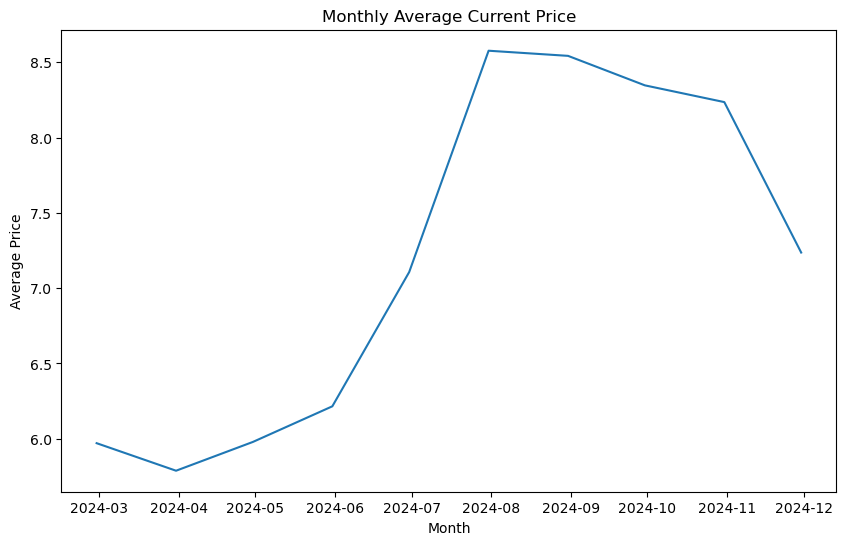

In [8]:
# Set 'nowtime' column as the index for resampling
merged_df_cleaned['nowtime'] = pd.to_datetime(merged_df_cleaned['nowtime'])
merged_df_cleaned.set_index('nowtime', inplace=True)

# 1. Monthly Time Series for Current Price (corrected for resampling with 'nowtime' as index)
numeric_columns = merged_df_cleaned.select_dtypes(include=['number']).columns
monthly_data = merged_df_cleaned[numeric_columns].resample('M').mean()

# Plot Monthly Average Current Price
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_data, x=monthly_data.index, y='current_price')
plt.title('Monthly Average Current Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()



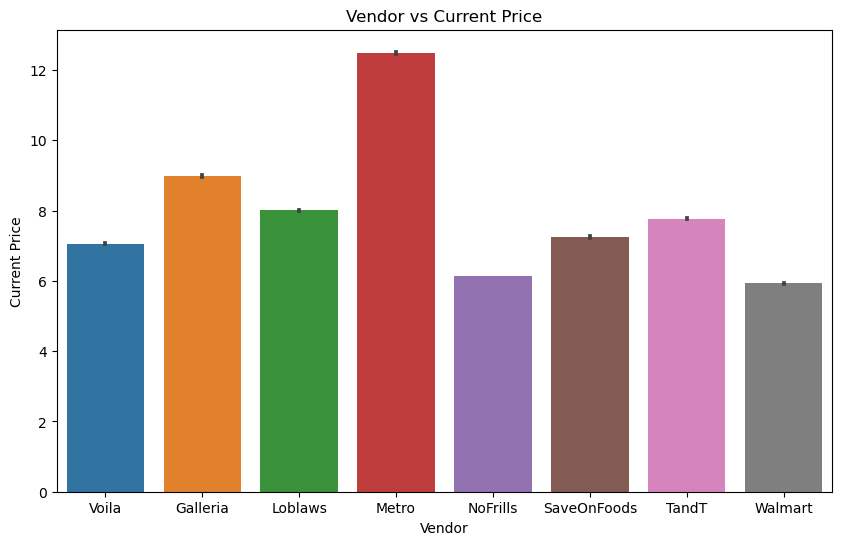

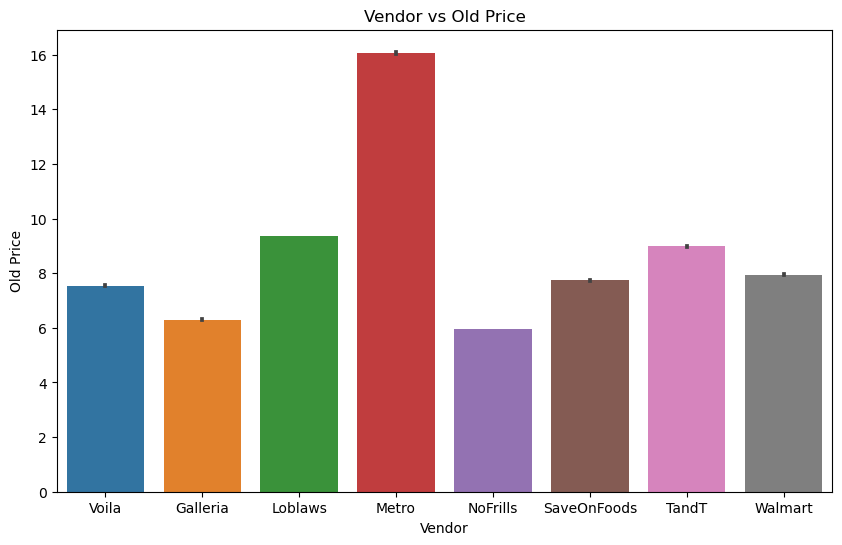

In [9]:
# 2. Bar Charts for Vendor vs Current Price and Old Price
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df_cleaned, x='vendor', y='current_price')
plt.title('Vendor vs Current Price')
plt.xlabel('Vendor')
plt.ylabel('Current Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df_cleaned, x='vendor', y='old_price')
plt.title('Vendor vs Old Price')
plt.xlabel('Vendor')
plt.ylabel('Old Price')
plt.show()


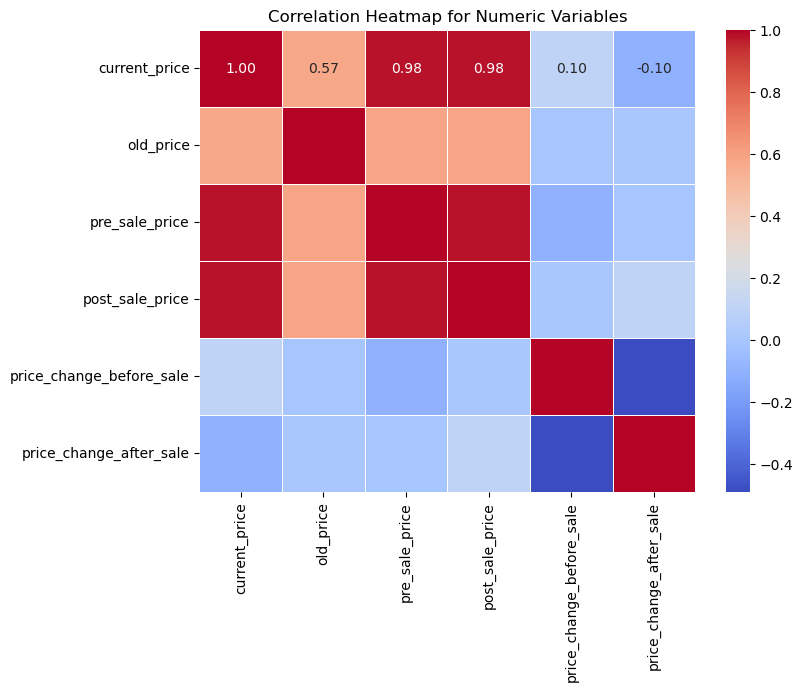

In [ ]:
# 3. Correlation Heatmap for Numeric Variables
numeric_data = merged_df_cleaned[['current_price', 'old_price', 'pre_sale_price', 'post_sale_price', 
                                 'price_change_before_sale', 'price_change_after_sale']]
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Numeric Variables')
plt.show()



In [ ]:
merged_df_cleaned.head()


,nowtime,current_price,old_price,other,product_id,vendor,product_name,units,pre_sale_price,post_sale_price,price_change_before_sale,price_change_after_sale
23,2024-07-02 09:55:00,6.49,6.49,NaN,3,Voila,Apples Ambrosia,1.36kg,6.49,NaN,0.0,NaN
22,2024-07-01 09:49:00,6.49,6.49,NaN,3,Voila,Apples Ambrosia,1.36kg,6.49,6.49,0.0,0.0
21,2024-06-30 09:37:00,6.49,6.49,NaN,3,Voila,Apples Ambrosia,1.36kg,6.49,6.49,0.0,0.0
20,2024-06-29 10:23:00,6.49,6.49,NaN,3,Voila,Apples Ambrosia,1.36kg,6.49,6.49,0.0,0.0
19,2024-06-28 10:54:00,6.49,6.49,NaN,3,Voila,Apples Ambrosia,1.36kg,6.49,6.49,0.0,0.0


In [ ]:
# 10. Calculate price changes before and after sales
merged_df_cleaned['price_change_before_sale'] = merged_df_cleaned['current_price'] - merged_df_cleaned['pre_sale_price']
merged_df_cleaned['price_change_after_sale'] = merged_df_cleaned['post_sale_price'] - merged_df_cleaned['current_price']

# 11. Filter for sale events and analyze the data
sale_price_change_df = merged_df_cleaned[merged_df_cleaned['other'] == 'SALE']

       price_change_before_sale  price_change_after_sale
count             402079.000000            401722.000000
mean                  -0.064090                 0.063414
std                    0.396036                 0.398004
min                  -25.000000                -6.500000
25%                    0.000000                 0.000000
50%                    0.000000                 0.000000
75%                    0.000000                 0.000000
max                    4.500000                14.000000


h:\Software\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


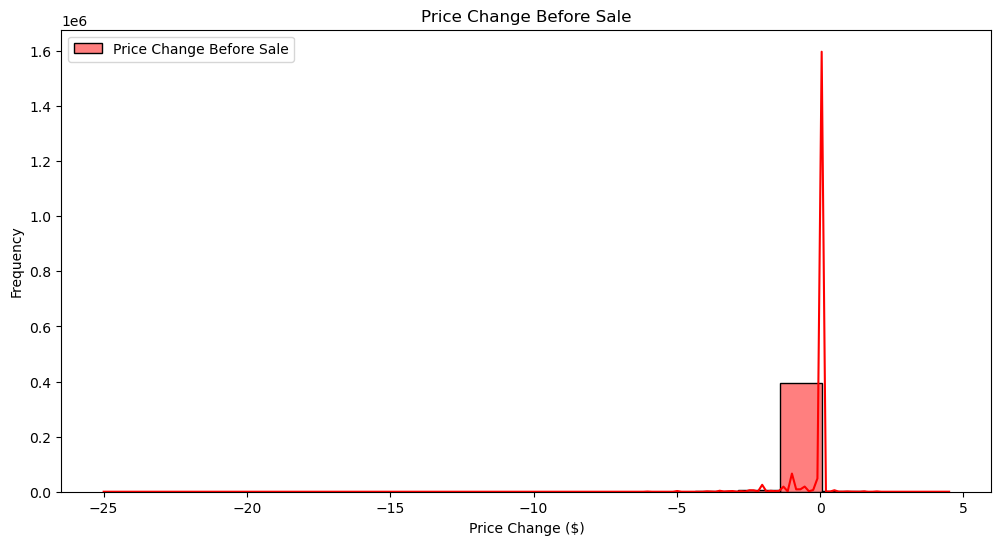

h:\Software\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


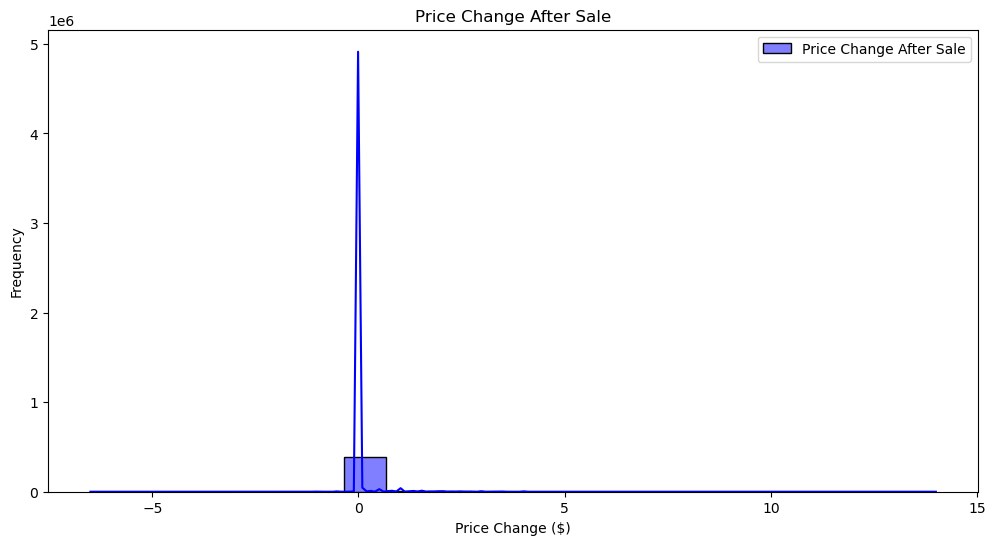

In [ ]:
# 12. Summary statistics for price changes before and after sales
print(sale_price_change_df[[ 'price_change_before_sale', 'price_change_after_sale']].describe())

# 13. Visualize the price trends before and after sales
plt.figure(figsize=(12, 6))

# Plot Price Before Sale
sns.histplot(sale_price_change_df['price_change_before_sale'], kde=True, color='red', label='Price Change Before Sale')
plt.title('Price Change Before Sale')
plt.xlabel('Price Change ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot Price After Sale
plt.figure(figsize=(12, 6))
sns.histplot(sale_price_change_df['price_change_after_sale'], kde=True, color='blue', label='Price Change After Sale')
plt.title('Price Change After Sale')
plt.xlabel('Price Change ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Check if prices increase before sales, and then decrease after sales.
increase_before_sale = sale_price_change_df[sale_price_change_df['price_change_before_sale'] > 0]
decrease_after_sale = sale_price_change_df[sale_price_change_df['price_change_after_sale'] < 0]

print(f"Number of products with price increase before sale: {len(increase_before_sale)}")
print(f"Number of products with price decrease after sale: {len(decrease_after_sale)}")

# Additional analysis to check the correlation between pre-sale and post-sale prices
correlation = sale_price_change_df[['price_change_before_sale', 'price_change_after_sale']].corr()
print(f"Correlation between price changes before and after sale:\n{correlation}")


Number of products with price increase before sale: 1188
Number of products with price decrease after sale: 1194
Correlation between price changes before and after sale:
                          price_change_before_sale  price_change_after_sale
price_change_before_sale                  1.000000                 0.024492
price_change_after_sale                   0.024492                 1.000000


In [ ]:
# Save the dataframe to a Parquet file

#erged_df_cleaned.to_parquet(os.path.join('..', 'Data', 'cleaned_price_data.parquet'), engine='pyarrow')
 